From: https://github.com/GoogleCloudPlatform/practical-ml-vision-book

Presented here in accordance with Apache License, Version 2.0

In [1]:
# Import libraries and modules
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

## Visualization utilities

In [2]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

def plot_label_clusters(encoder, data, labels, vae=True):
    # display a 2D plot of the digit classes in the latent space
    if vae:
      z_mean, _, _ = encoder.predict(data)
    else:
      z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10): # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(cx, cy, str(label), color="white", fontsize=25, fontweight="bold")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Variational Autoencoder

This is similar to the [10a_autoencoder.ipynb](10a_autoencoder.ipynb) except that we sample the mean and variance of the latent dimension.

Use Keras utilities to load MNIST data

In [3]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

The variational encoder uses (z_mean, z_log_var) to sample the vector that encodes a digit.

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

The encoder goes from the inputs to the latent dim, but because we have multiple outputs, we have to use the functional style

In [5]:
latent_dim = 2 # for easy visualization

encoder_inputs = keras.Input(shape=(28, 28, 1), name="image_input")
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same", name="e_conv1")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same", name="e_conv2")(x)
x = layers.Flatten(name="e_flatten")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x) # the autoencoder output
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()(z_mean, z_log_var)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 e_conv1 (Conv2D)               (None, 14, 14, 32)   320         ['image_input[0][0]']            
                                                                                                  
 e_conv2 (Conv2D)               (None, 7, 7, 64)     18496       ['e_conv1[0][0]']                
                                                                                                  
 e_flatten (Flatten)            (None, 3136)         0           ['e_conv2[0][0]']                
                                                                                            

The decoder goes from the latent dim back to the reconstructed image:

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,), name="d_input")
x = layers.Dense(7 * 7 * 64, activation="relu", name="d_d1")(latent_inputs)
x = layers.Reshape((7, 7, 64), name="d_d2")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same", name="d_conv1")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", strides=2, padding="same", name="d_conv2")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 d_input (InputLayer)        [(None, 2)]               0         
                                                                 
 d_d1 (Dense)                (None, 3136)              9408      
                                                                 
 d_d2 (Reshape)              (None, 7, 7, 64)          0         
                                                                 
 d_conv1 (Conv2DTranspose)   (None, 14, 14, 32)        18464     
                                                                 
 d_conv2 (Conv2DTranspose)   (None, 28, 28, 1)         289       
                                                                 
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


The encoder's loss is KL divergence.

In [7]:
def kl_divergence(z_mean, z_log_var):
    kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
    return tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
encoder.add_loss(kl_divergence(z_mean, z_log_var))

The autoencoder consists of the encoder and the decoder blocks. We can write it as a Keras Functional model

In [8]:
z_mean, z_log_var, z = encoder(encoder_inputs) # 3 outputs now
decoder_output = decoder(z)
vae = keras.Model(encoder_inputs, decoder_output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               31364     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         28161     
                                                                 
Total params: 59,525
Trainable params: 59,525
Non-trainable params: 0
_________________________________________________________________


The overall reconstruction loss is the sum of binary per-pixel losses

In [9]:
def reconstruction_loss(real, reconstruction):
  return tf.reduce_mean(
      tf.reduce_sum(
          keras.losses.binary_crossentropy(real, reconstruction), axis=(1, 2)
      )
  )

vae.compile(optimizer=keras.optimizers.Adam(), loss=reconstruction_loss, metrics=["mse"])

In [10]:
history = vae.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 14s 22ms/step - loss: 210.6828 - mse: 0.0673
Epoch 2/30
547/547 [==============================] - 13s 25ms/step - loss: 169.3815 - mse: 0.0507
Epoch 3/30
547/547 [==============================] - 14s 26ms/step - loss: 164.1164 - mse: 0.0481
Epoch 4/30
547/547 [==============================] - 14s 25ms/step - loss: 161.3704 - mse: 0.0467
Epoch 5/30
547/547 [==============================] - 21s 39ms/step - loss: 159.8480 - mse: 0.0460
Epoch 6/30
547/547 [==============================] - 22s 40ms/step - loss: 158.7533 - mse: 0.0454
Epoch 7/30
547/547 [==============================] - 22s 40ms/step - loss: 158.0344 - mse: 0.0451
Epoch 8/30
547/547 [==============================] - 22s 41ms/step - loss: 157.4042 - mse: 0.0447
Epoch 9/30
547/547 [==============================] - 23s 42ms/step - loss: 156.9265 - mse: 0.0445
Epoch 10/30
547/547 [==============================] - 22s 41ms/step - loss: 156.5165 - mse: 0.0443
Epoch 11/

1875/1875 [==============================] - 3s 2ms/step


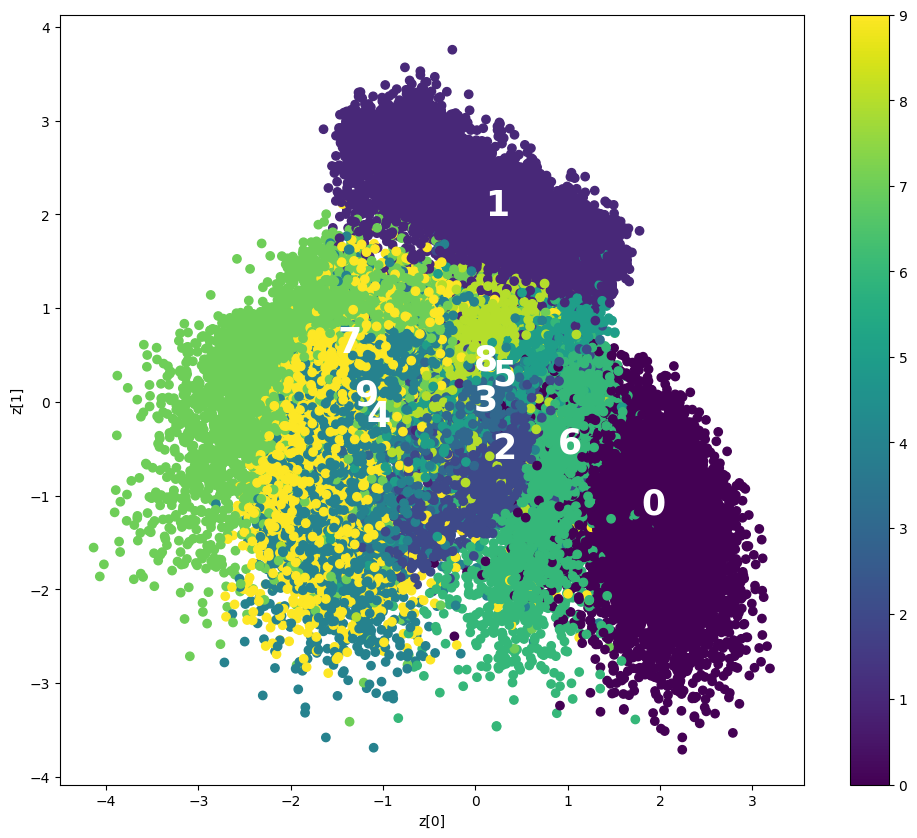

In [11]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train, vae=True)

1/1 [==============================] - 0s 21ms/step


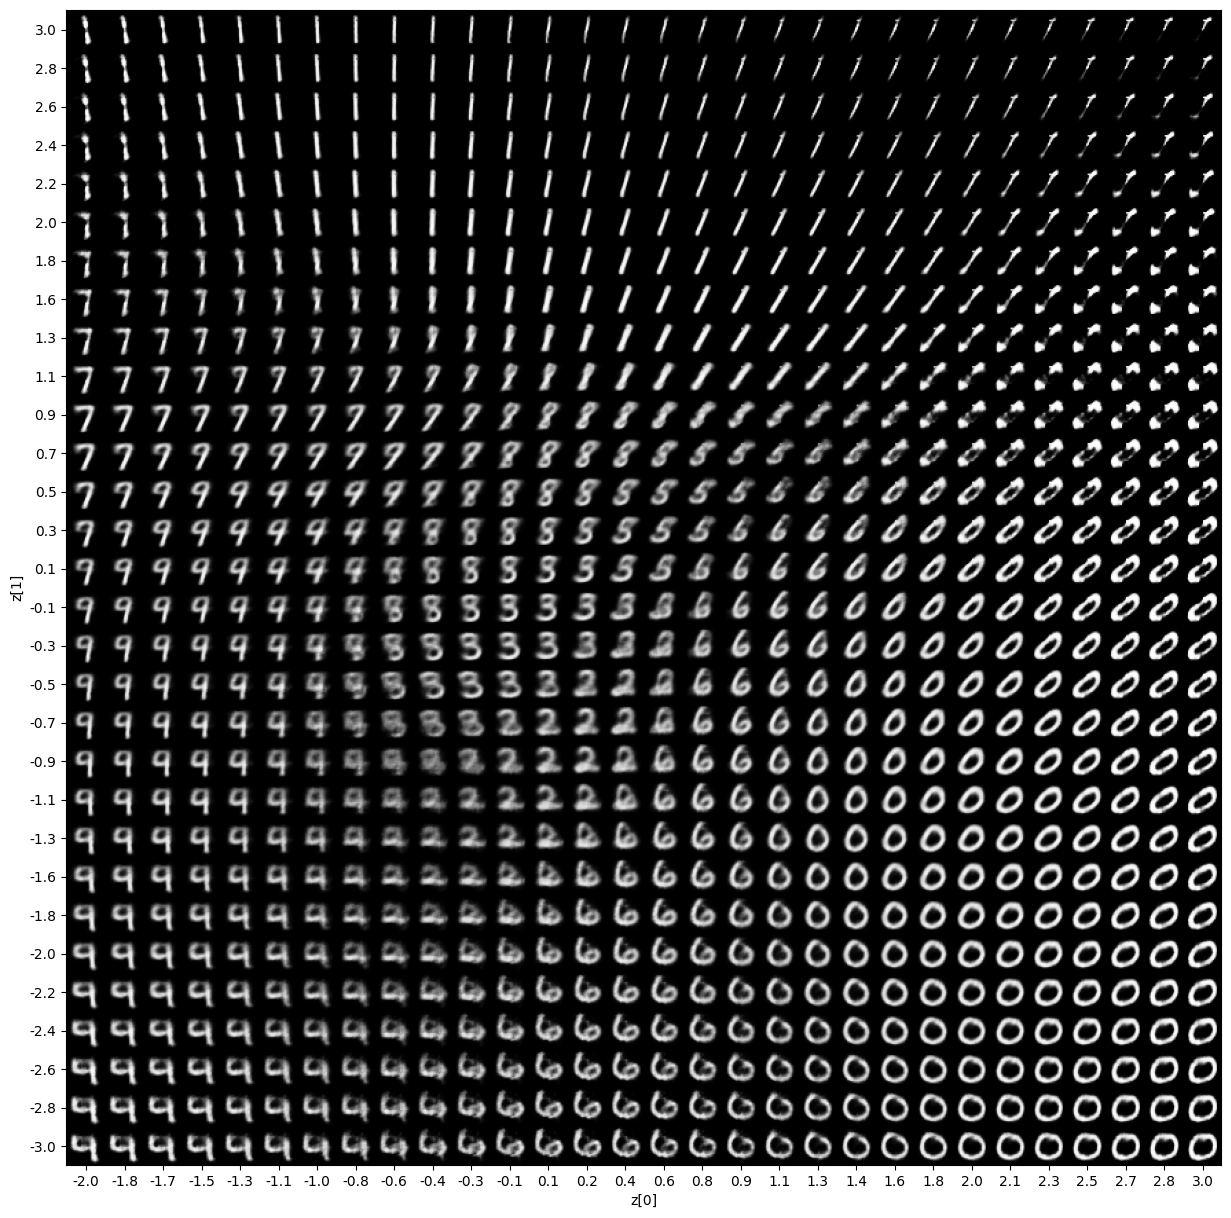

In [12]:
plot_latent_space(decoder, n=30, ranges=[-2, 3, -3, 3], figsize=15)